End to End classifier that helps to classify Wikipedia comments

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

In [7]:
data = pd.read_csv('/content/train_comment_small.csv', encoding='utf-8')

In [8]:
data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Generic Function for the classifier

In [9]:
def clf_model(model_type, X_train, y_train, X_valid):
  model = model_type.fit(X_train, y_train)
  predicted_labels = model.predict(X_valid)
  predicted_probab = model.predict_proba(X_valid)[:,1]
  return [predicted_labels, predicted_probab, model]

Generic function for Evaluation

In [27]:
def model_evaluation(actual_values, predicted_values, predicted_probabilites):
  cfn_mat = confusion_matrix(actual_values, predicted_values)
  print("Confusion Matrix: \n", cfn_mat)
  print("\naccuracy: ", accuracy_score(actual_values, predicted_values))
  print("\nclassification report: \n", classification_report(actual_values, predicted_values))
  fpr, tpr, threshold = roc_curve(actual_values, predicted_probabilites)
  print("\nArea under ROC curve for validation set:", auc(fpr,tpr))
  fig,ax = plt.subplots(figsize=(6,6))
  ax.plot(fpr,tpr,label='Validation Set AUC')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  ax.legend(loc='best')
  plt.show()

In [18]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_comment_text'] = data['comment_text'].apply(\
lambda x: ' '.join([lemmatizer.lemmatize(word.lower())\
for word in word_tokenize(re.sub(r'([^\s\w]|_)+',' ', str(x))) if word.lower() not in stop_words]))

Creating Tf-Idf matrix representation of these cleaned text

In [22]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_comment_text']).todense())
tfidf_df.column = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.537391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train Test Split - Dividing dataset into training and validation dataset

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['toxic'], test_size=0.2,
                                                      random_state=42, stratify=data['toxic'])

Logistic Regression Model

Confusion Matrix: 
 [[28675   181]
 [ 1727  1332]]

accuracy:  0.9402161992793358

classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     28856
           1       0.88      0.44      0.58      3059

    accuracy                           0.94     31915
   macro avg       0.91      0.71      0.78     31915
weighted avg       0.94      0.94      0.93     31915


Area under ROC curve for validation set: 0.905014635466452


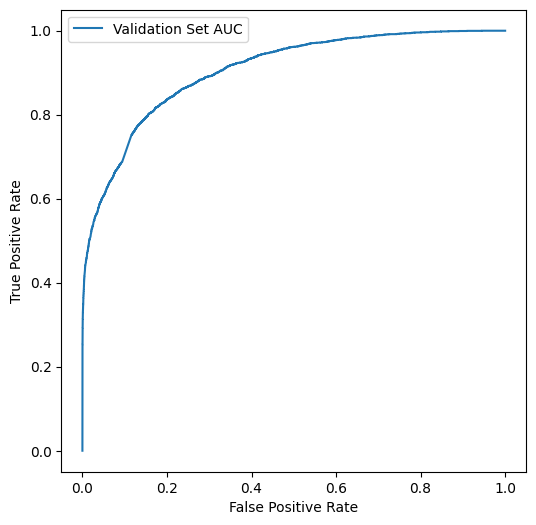

In [28]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
results = clf_model(logreg, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])

Random Forest Model

Confusion Matrix: 
 [[28856     0]
 [ 2989    70]]

accuracy:  0.9063449788500705

classification report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     28856
           1       1.00      0.02      0.04      3059

    accuracy                           0.91     31915
   macro avg       0.95      0.51      0.50     31915
weighted avg       0.92      0.91      0.86     31915


Area under ROC curve for validation set: 0.8534135253153194


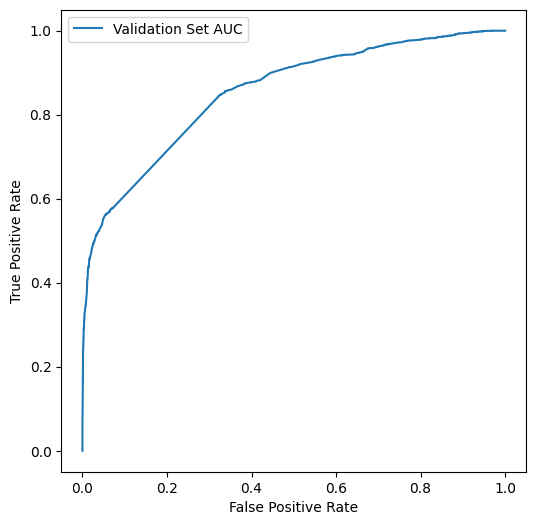

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, max_depth=4, max_features='sqrt', random_state=1)
results = clf_model(rfc, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_rfc = results[2]

extract important features - words critical in determining the comment to be toxic

In [30]:
word_importances = pd.DataFrame({'word':X_train.columns, 'importance':model_rfc.feature_importances_})
word_importances.sort_values('importance', ascending=False).head(4)

,word,importance
455,455,0.190214
49,49,0.179870
42,42,0.160388
280,280,0.047431


XGBoost Model

Confusion Matrix: 
 [[28856     0]
 [ 2959   100]]

accuracy:  0.9072849757167476

classification report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     28856
           1       1.00      0.03      0.06      3059

    accuracy                           0.91     31915
   macro avg       0.95      0.52      0.51     31915
weighted avg       0.92      0.91      0.87     31915


Area under ROC curve for validation set: 0.7948677227446214


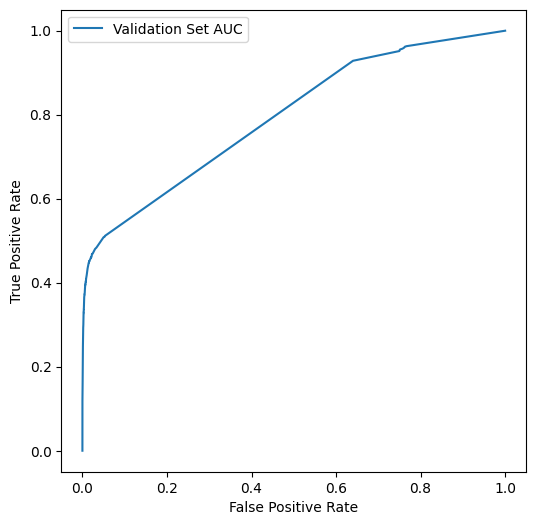

In [31]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=20, learning_rate=0.03, max_depth=5, subsample=0.6,
                        colsample_bytree=0.6, reg_alpha=10, seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

In [32]:
word_importances = pd.DataFrame({'word':X_train.columns, 'importance':model_xgb.feature_importances_})
word_importances.sort_values('importance', ascending=False).head(4)

,word,importance
455,455,0.322232
49,49,0.161780
469,469,0.077448
413,413,0.074033
